
## Build grid and Galerkin ingredients
We discretize the square with a uniform grid for output and assemble the 1-D Legendre basis on the physical domain. The squared exponential kernel
$$ k(x, x') = \sigma^2 \exp\left(-\frac{\lVert x - x' \rVert^2}{2 \ell^2}\right)
= \sigma^2 e^{-b (x_1 - x_1')^2} e^{-b (x_2 - x_2')^2}, \quad b = \tfrac{1}{2\ell^2} $$
is separable across dimensions, so the 2-D Galerkin operator reduces to a Kronecker product of identical 1-D blocks.



## Loader class for evaluation and sampling
The class below reads the exported HDF5, reconstructs the truncated basis, and exposes methods to evaluate fields from user-provided coefficients or to draw random samples.


In [6]:
import h5py
import numpy as np
class SquareExponentialField:
    """Load and evaluate a truncated squared exponential decomposition."""

    def __init__(self, mean, eigenvalues, eigenvectors, grid_x, grid_y):
        self.mean = float(mean)
        self.eigenvalues = np.asarray(eigenvalues, dtype=float)
        self.sqrt_eigenvalues = np.sqrt(self.eigenvalues)
        # Eigenvectors stored as (modes, n_points)
        self.eigenvectors = np.asarray(eigenvectors, dtype=float)
        self.grid_x = np.asarray(grid_x, dtype=float)
        self.grid_y = np.asarray(grid_y, dtype=float)
        self.grid_shape = (len(self.grid_x), len(self.grid_y))

    @classmethod
    def from_hdf5(cls, path):
        with h5py.File(path, "r") as f:
            mean = f.attrs["mean"]
            eigenvalues = f["eigenvalues"][:]
            eigenvectors = f["eigenvectors"][:]
            grid_x = f["grid_x"][:]
            grid_y = f["grid_y"][:]
        return cls(mean=mean, eigenvalues=eigenvalues, eigenvectors=eigenvectors, grid_x=grid_x, grid_y=grid_y)

    def evaluate(self, coefficients=None):
        """Evaluate the truncated expansion on the stored grid.

        Args:
            coefficients: Optional array of shape (modes,) or (n_samples, modes).
                Defaults to zeros (producing the mean field).

        Returns:
            Field values with shape (grid_x.size, grid_y.size) if coefficients is 1D,
            or (n_samples, grid_x.size, grid_y.size) if 2D.
        """
        if coefficients is None:
            coefficients = np.zeros((self.eigenvectors.shape[0],), dtype=float)
        coeffs = np.asarray(coefficients, dtype=float)

        single_input = coeffs.ndim == 1
        if single_input:
            coeffs = coeffs[None, :]

        if coeffs.shape[1] != self.eigenvectors.shape[0]:
            raise ValueError("Coefficient dimension does not match number of modes")

        weighted_modes = coeffs * self.sqrt_eigenvalues[None, :]
        fields = weighted_modes @ self.eigenvectors
        fields = fields + self.mean

        if single_input:
            return fields.reshape(self.grid_shape)
        return fields.reshape((-1, *self.grid_shape))

    def sample(self, n_samples=1, rng=None):
        """Draw random field samples using standard normal coefficients."""
        rng = np.random.default_rng(rng)
        coeffs = rng.standard_normal(size=(n_samples, self.eigenvectors.shape[0]))
        return self.evaluate(coeffs)


## Example usage
Load the saved JSON, draw a couple of random samples, and inspect their shapes.


In [7]:

field = SquareExponentialField.from_hdf5("square_exponential_decomposition.h5")

# Evaluate the mean field (all coefficients zero)
mean_field = field.evaluate()
extent = (-5.0, 5.0)
# Draw a few random samples
few_samples = field.sample(n_samples=3, rng=0)

mean_field.shape, few_samples.shape

((101, 101), (3, 101, 101))

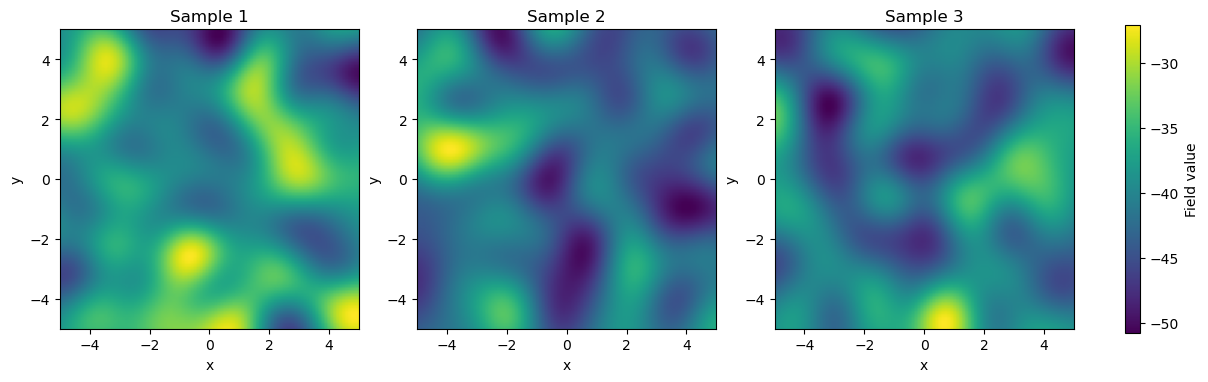

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, few_samples.shape[0], figsize=(4 * few_samples.shape[0], 4), constrained_layout=True)
axes = np.atleast_1d(axes)

for idx, (ax, sample) in enumerate(zip(axes, few_samples)):
    im = ax.imshow(
        sample,
        origin="lower",
        extent=(extent[0], extent[1], extent[0], extent[1]),
        cmap="viridis"
    )
    ax.set_title(f"Sample {idx + 1}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

fig.colorbar(im, ax=axes, shrink=0.8, label="Field value")
plt.show()